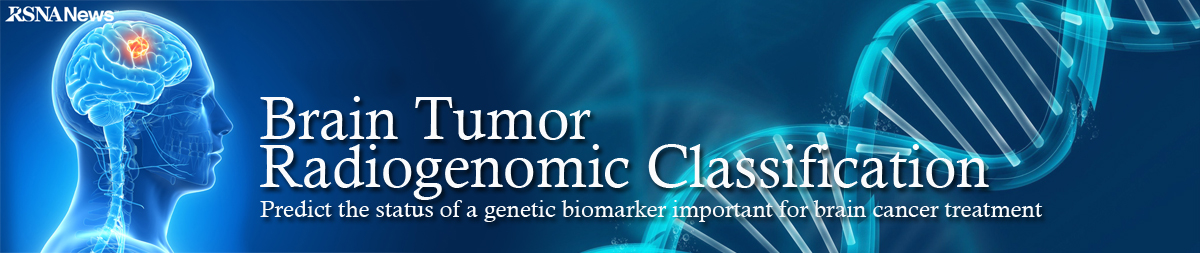

## CONTEXT
The goal of this competition, initiated by the Radiological Society of North America (RSNA) in partnership with the Medical Image Computing and Computer Assisted Intervention Society (the MICCAI Society) is to predict the methylation of the MGMT promoter, which is an important gene biomarker for treatment of brain tumors.

These predictions will be based on a database of MRI (magnetic resonance imaging) scans of several hundred patients.



## DATA
Each independent case has a dedicated folder identified by a five-digit number. Within each of these “case” folders, there are four sub-folders, each of them corresponding to each of the structural multi-parametric MRI (mpMRI) scans, in DICOM format. The exact mpMRI scans included are:

- Fluid Attenuated Inversion Recovery (FLAIR)
- T1-weighted pre-contrast (T1w)
- T1-weighted post-contrast (T1Gd)
- T2-weighted (T2)


### Import Dependencies

In [ ]:
import os
import glob
import re
import math
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Load the Data

In [ ]:
data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/'

train_df = pd.read_csv(data_directory+"train_labels.csv")
train_df['BraTS21ID5'] = [format(x, '05d') for x in train_df.BraTS21ID]
train_df.head()

Test data:-

In [ ]:
test = pd.read_csv(
    data_directory+'sample_submission.csv')

test['BraTS21ID5'] = [format(x, '05d') for x in test.BraTS21ID]
test.head(3)

# IMAGE PREPROCESSING
For each patient, we will carry out a pre-processing of the images by applying these different modifications:

- Load an ordered sequence of 64 MRI scan
- Crop images to reduce black borders
- Resize image for pre-train model
- Apply denoising filter
- Convert each image in 3D array

In [ ]:
IMAGE_SIZE = 240
SCALE = .8
NUM_IMAGES = 64
MRI_TYPE = "FLAIR"

In [ ]:
# Load Single Image
def load_dicom_image(
    path,
    img_size = IMAGE_SIZE,
    scale = SCALE):
    '''
    This function allows you to load a DCIM type image 
    and apply preprocessing steps such as crop, resize 
    and denoising filter to it.
    ****************************************************
    PARAMETERS
    ****************************************************
    - path : String
        Path to the DCIM image file to load.
    - img_size : Integer
        Image size desired for resizing.
    - scale : Float
        Desired scale for the cropped image
    - prep : Bool
        True for a full preprocessing with
        denoising.
    '''
    # Load single image
    img = dicom.read_file(path).pixel_array
    # Crop image
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    # Resize image
    img = cv2.resize(img, (img_size, img_size))
    
    # Convert in 3D array
    img = np.repeat(img[..., np.newaxis], 3, -1)
    
    return img

We can check the result of these different preprocessing steps on a random patient:

In [ ]:
sample_img = dicom.read_file(data_directory+"train/00046/FLAIR/Image-90.dcm").pixel_array

preproc_img = load_dicom_image(data_directory+"train/00046/FLAIR/Image-90.dcm")

fig = plt.figure(figsize = (12, 8))
ax1 = plt.subplot(1,2,1)
ax1.imshow(sample_img, cmap="gray")
ax1.set_title(f"Original image shape = {sample_img.shape}")
ax2 = plt.subplot(1,2,2)
ax2.imshow(preproc_img[:,:,0], cmap="gray")
ax2.set_title(f"After Preprocessing = {preproc_img.shape}")
plt.show()

### LOAD SEQUENCE OF 64 PREPROCESSED IMAGES

In [ ]:
def load_dicom_images_3d(
    scan_id,
    num_imgs = NUM_IMAGES,
    img_size = IMAGE_SIZE,
    mri_type = MRI_TYPE,
    split = "train"):
    '''
    This function allows loading an ordered sequence 
    of x preprocessed images starting from the central 
    image of each folder.
    ****************************************************
    PARAMETERS
    ****************************************************
    - scan_id : String
        ID of the patient to load.
    - num_imgs : Integer
        Number of desired images of the 
        sequence.
    - img_size : Integer
        Image size desired for resizing.
    - scale : Float
        Desired scale for the cropped image
    - mri_type : String
        Type of scan to load (FLAIR, T1w, 
        T1wCE, T2).
    - split : String
        Type of split desired : Train or Test
    '''
    files = sorted(glob.glob(f"{data_directory}{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    middle = len(files) // 2
    num_imgs2 = num_imgs // 2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f) for f in files[p1:p2]])
    if img3d.shape[0] < num_imgs:
        n_zero = np.zeros((num_imgs - img3d.shape[0], img_size, img_size, 3))
        img3d = np.concatenate((img3d, n_zero), axis = 0)
        
    return img3d

Here again we can test the loading of a sequence of preprocessed images for a patient:

In [ ]:
sample_seq = load_dicom_images_3d("00046")
print("Shape of the sequence is :-", sample_seq.shape)
print("Dimension of the 15th image in sequence is:-", sample_seq[15].shape)
fig = plt.figure(figsize = (5,5))
plt.imshow(np.squeeze(sample_seq[15][:,:,0]), cmap="gray")
plt.show()

## LOAD PRE-TRAINED RESNET50 MODEL
To carry out the Transfer Learning on each image of the sequence, we will load a pre-trained model thanks to Keras.applications with the pre-trained weights on ImageNet.
As the notebook must be without Internet for the competition, the weights are loaded separately and imported from a specially created Dataset (../input/resnet-imagenet-weights).

Here we will chrger the ResNet50 model, knowing that other models have been tested such as ResNet50 and Xception.



In [ ]:
base_resnet = keras.applications.ResNet50(
    weights = None,
    pooling = "avg",
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top = False)

In [ ]:
base_resnet.save_weights(
    'base_resnet_imagenet.h5')

In [ ]:
base_resnet.load_weights(
    './base_resnet_imagenet.h5')


We are also going to fix all the layers of the model so that they are not re-trained for the detection of features. The classification layer is also not loaded (include_top = False).

In [ ]:
base_resnet.trainable = False

## CREATE A MATRIX OF VECTORS BASE ON RESNET50 FOR EACH PATIENT SEQUENCE
For this part of Transfer Learning, we will not train the ResNet50 model but only perform the prediction for each image of the sequence of each patient.
We will thus obtain, for each image, a matrix of the model weights that we will integrate into a list to recreate the patient sequence.
Finally, we are going to create a global matrix which will group together the sequences of x ResNet50.predict matrices for all the patients.

Let's look at the pseudo-code:

In [ ]:
# Transfert Learning
# listMatrix = []
# for person in persons:
#     listVectors = []
#     for image in person.images:
#         img = preprocess(image)
#         vector = baseModel.predict(img)
#         listVectors.append(vector)

#     PatientMatrix = np.stack(listVectors)
#     listMatrix.append(PatientMatrix)

In [ ]:
train = train_df[['BraTS21ID5','MGMT_value']]
X_train = train['BraTS21ID5'].values
y_train = train['MGMT_value'].values

We will apply this process for just one type of MRI scans (here is T1w type) for each patient. Each patient will therefore have 24 images for treatment.

In [ ]:
listMatrix = []
for i, patient in enumerate(tqdm(X_train)):
    listVectors = []
    sequence = load_dicom_images_3d(scan_id=str(patient),mri_type=MRI_TYPE)
    for j in range(len(sequence)):
        img = sequence[j]
        img = np.expand_dims(img, axis=0)
        img = tf.keras.applications.resnet50.preprocess_input(img)
        img_vector = base_resnet.predict(img)
        listVectors.append(np.array(img_vector))
    
    PatientMatrix = np.stack(listVectors)
    listMatrix.append(PatientMatrix)

Let us now look at the shapes of the matrices obtained following the application of this Learning Transfer:

In [ ]:
print(f"Number of Patient matrix: {len(listMatrix)}")
print(f"Patient matrix shape: {listMatrix[0].shape}")

In [ ]:
np.array(listMatrix, dtype = object).shape

## APPLY LSTM FOR CLASSIFICATION
Recurrent neural networks (RNNs) are widely used in artificial intelligence when a temporal notion is involved in the data.

LSTM is a complex and very powerful algorithm which will allow in our case to take into account the past elements of our sequence of images.

In [ ]:
model_input_dim = listMatrix[0].shape[2]
model_input_dim

In [ ]:
# Create a function for lstm model
def get_sequence_model():
    '''Define the LSTM architecture'''
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(100, input_shape=(NUM_IMAGES, model_input_dim), return_sequences=True))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

We will now train this LSTM model on the matrices compiled for each patient using the Transfer Learning ResNet50.

An EarlyStopping is set up and the best model will be saved

In [ ]:
from sklearn.model_selection import KFold

inputs = np.array(listMatrix)
targets = np.array(y_train).astype('float32').reshape((-1,1))

num_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
history = {}
fold_no = 1
for train_df, valid_df in kfold.split(inputs, targets):
    
    train_dataset = tf.data.Dataset.from_tensor_slices((inputs[train_df], targets[train_df]))
    valid_dataset = tf.data.Dataset.from_tensor_slices((inputs[valid_df], targets[valid_df]))
    
    model = get_sequence_model()
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics='accuracy')
    
    # Define callbacks.
    model_save = ModelCheckpoint(f'Brain_lstm_kfold_{fold_no}.h5', 
                                 save_best_only = True, 
                                 monitor = 'val_accuracy', 
                                 mode = 'max', verbose = 1)
    early_stop = EarlyStopping(monitor = 'val_accuracy', 
                               patience = 25, mode = 'max', verbose = 1,
                               restore_best_weights = True)
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    epochs = 200
    history[fold_no] = model.fit(
        train_dataset,
        validation_data=valid_dataset, 
        epochs=epochs, 
        batch_size=32,
        callbacks = [model_save, early_stop])
    
    # Increase fold number
    fold_no += 1

Now let's look at the results of this training:

In [ ]:
fig , ax = plt.subplots(1 , 2, figsize=(20,7))
ax = ax.ravel()

for fold in history:
    for i, metric in enumerate(["accuracy", "loss"]):
        ax[i].plot(history[fold].history[metric], label="train"+str(fold))
        ax[i].plot(history[fold].history["val_" + metric], linestyle="dotted", label="val"+str(fold))
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend()

In [ ]:
kfold_results = pd.DataFrame(columns=["Fold","Mean_Loss","Mean_Accuracy"])
key = []
mean_loss = []
mean_acc = []
for fold in history:
    key.append(fold), 
    mean_loss.append(np.mean(history[fold].history["val_loss"]))
    mean_acc.append(np.mean(history[fold].history["val_accuracy"]))

kfold_results["Fold"] = key
kfold_results["Mean_Loss"] = mean_loss
kfold_results["Mean_Accuracy"] = mean_acc
kfold_results["Rank_Ratio"] = (kfold_results["Mean_Loss"] - kfold_results["Mean_Accuracy"])
kfold_results = kfold_results.sort_values("Rank_Ratio", ascending=True)
kfold_results

In [ ]:
best_kfold_model = './Brain_lstm_kfold_' + str(kfold_results.Fold.values[0]) + '.h5'
print(f"The best select model is {best_kfold_model}")

## PREDICT ON TEST SET WITH BEST MODEL
We will now create the ResNet50 matrices for the test set and make the predictions on the test patients.

In [ ]:
X_test = test['BraTS21ID5'].values
test_listMatrix = []
for i, patient in enumerate(tqdm(X_test)):
    test_listVectors = []
    test_sequence = load_dicom_images_3d(scan_id=str(patient),mri_type=MRI_TYPE,split="test")
    for j in range(len(test_sequence)):
        img = test_sequence[j]
        img = np.expand_dims(img, axis=0)
        img = tf.keras.applications.resnet50.preprocess_input(img)
        img_vector = base_resnet.predict(img)
        test_listVectors.append(np.array(img_vector))
    
    test_PatientMatrix = np.stack(test_listVectors)
    test_listMatrix.append(test_PatientMatrix)

In [ ]:
print(f"Number of test patient matrix: {len(test_listMatrix)}")
print(f"Test patient matrix shape: {test_listMatrix[0].shape}")

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_listMatrix)
len(test_dataset)

In [ ]:
final_model = keras.models.load_model(best_kfold_model)
predict = final_model.predict(test_dataset)
print(predict.shape)

In [ ]:
predict = predict[:,0,0]
final_predict = []
for i in range(len(test_listMatrix)):
    i+=1
    final_predict.append(round(predict[((i-1)*NUM_IMAGES):(NUM_IMAGES*i)].mean(),3))
submission = test[["BraTS21ID","MGMT_value"]]
submission["MGMT_value"] = final_predict
submission.to_csv('submission.csv',index=False)
submission.head(5)

In [ ]:
plt.figure(figsize=(8, 8))
plt.hist(submission["MGMT_value"])
plt.title("Predicted probabilites distribution on test set", 
          fontsize=18, color="#0b0a2d")
plt.show()